In [ ]:
! pip install xlrd

In [1]:
import pandas_profiling as pp
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
! ls -l ../data/original

total 1976272
-rw-rw-r-- 1 ubuntu ubuntu     210907 Jan 25 18:30 1916-2019-01-25-15-00-34.zip
-rw-rw-r-- 1 ubuntu ubuntu    1641746 Jan 25 17:33 atc-icd-mialist.csv
-rw-rw-r-- 1 ubuntu ubuntu    2740224 Jan 25 17:23 BE_COD_2015_FR_v1.xls
-rw-rw-r-- 1 ubuntu ubuntu    2743296 Jan 25 17:23 BE_COD_2015_NL_v2.xls
-rw-rw-r-- 1 ubuntu ubuntu      13946 Jan 25 17:22 Care place service.xlsx
-rw-rw-r-- 1 ubuntu ubuntu    1585669 Jan 25 17:22 csv4Emd_Fr_1901A.zip
-rw-rw-r-- 1 ubuntu ubuntu    1552530 Jan 25 17:22 csv4Emd_Nl_1901A.zip
-rw-rw-r-- 1 ubuntu ubuntu     782180 Jan 25 17:22 csv_ATCDPP_1808A.zip
-rw-rw-r-- 1 ubuntu ubuntu     641368 Jan 25 17:22 csv_VOSDCI_1901A.zip
-rw-rw-r-- 1 ubuntu ubuntu    5330821 Jan 25 17:22 d20061027316.pdf
-rw-rw-r-- 1 ubuntu ubuntu       4243 Jan 25 18:31 dataforbetterhealth-master.zip
-rw-rw-r-- 1 ubuntu ubuntu     152496 Jan 25 17:21 db4emd-docEN.pdf
-rw-r--r-- 1 ubuntu ubuntu 1812381904 Jan 28 11:38 DB_V2.TXT
-rw-rw-r-- 1 ubuntu ubuntu     357479 Jan 25 17

In [3]:
! head ../data/original/DB_V2.TXT

## loading the data

In [2]:
# RIZIV dataset 1.8GB
df = pd.read_csv("../data/original/DB_V2.TXT", sep='\t', encoding='latin-1', low_memory=False)
df.drop_duplicates(inplace=True)

In [ ]:
pp.ProfileReport(df).to_file(outputfile="../data/report/DB_V2_initial_dataset_report.html")

In [3]:
# fixed the drug_code issue for later merging
pharma_ref = pd.read_excel("../data/original/PHARMA_REF.xlsx", dtype={"drug_code":'str'})
pharma_ref.drop_duplicates(inplace=True)

In [26]:
pp.ProfileReport(pharma_ref).to_file(outputfile="../data/report/PHARMA_REF_xlsx_initial_dataset_report.html")

In [9]:
reimburse_cat = pd.read_excel("../data/original/reimb category.xlsx")
reimburse_cat.drop_duplicates(inplace=True)

In [29]:
pp.ProfileReport(reimburse_cat).to_file(outputfile="../data/report/reimb_category_xlsx_initial_dataset_report.html")

## df datacleaning

In [5]:
df.drop('Year', axis=1, inplace=True)
df.drop('account_yy_ss', axis=1, inplace=True)

## pharma_ref datacleaning

### Big mistake here !

keep it as a string object to merge properly !

In [4]:
for id in pharma_ref["drug_code"].unique():
    if len(id) != 7:
        print (id)
        # this should reply 0 amount of id's

In [6]:
for id in df["drug_code"].unique():
    if len(id) != 7:
        print (id)
        # this should reply 0 amount of id's

In [6]:
#pharma_ref["drug_code"] = pharma_ref["drug_code"].astype("category")
# V2         has 24754 unique values here it has these codes occuring sometimes 
# pharma_ref has 36898 unique values all 100% unique

# and we have to make sure pharma_ref["drug_code"] is changed to string object values and you need to map/replace
# for example      0 to 0000000
# for example 136168 to 0136168, etc...

# then when you merge you can use how='outer', indicator=True
# special column "_merge" what you want (both, left_only, right_only)

## reimburse_cat datacleaning

In [11]:
reimburse_cat_dict = {'nd':'other', 'A':'A', 'B':'B', 'Cat 1':'other', 'Cat 2 (A)':'other', 'Cat 3':'other', 'Cat 4':'other',
       'Cat 5 (D)':'other', 'C':'C', 'Cs':'C', 'Cx':'C', 'Cxg':'C', 'D':'D', 'Csg':'C', 'Ag':'A', 'Bg':'B', 'Cg':'C',
       'Forf Ant':'other', 'Nutri Par':'other', 'Br':'other', 'Ar':'other', 'Cr':'C', 'Csr':'C', 'Cxr':'C',
       'Forf Adm':'other', 'Forf BH':'forf', 'V08':'other', 'Fa':'other', 'Fb':'other', 'Forf 1-3':'other',
       'Forf 4-':'other', 'Ri-D11':'other', 'Ri-T1':'other', 'Ri-T2':'other', 'Ri-T3':'other', 'Ri-D5':'other', 'Ri-D7':'other',
       'Ri-D2':'other', 'Ri-D9':'other', 'Ri-D6':'other', 'Ri-D10':'other', 'Ri-D3':'other', 'Ri-D1':'other', 'Ri-D8':'other',
       'Ri-T4':'other', 'Ri-D4':'other', 'Forf PET':'other', '90-A':'A', '90-B':'B', '90-Fa':'other', '90-Fb':'other',
       'Ri-T5':'other', 'Ri-T6':'other', 'Ri-T7':'other', 'Ri-T8':'other', '90-C':'C', '90-Cs':'C', '90-Cx':'C'}

In [12]:
reimburse_cat["reimbt_crit_long"] = reimburse_cat["reimbt_crit_long"].map(reimburse_cat_dict)

In [13]:
# only keep hospitalised data, ignore ambulant data
reimburse_cat_hosp = reimburse_cat[ (reimburse_cat["patient_cat"] == 'HOSP') ]

In [14]:
# max_pct is highly correlated with min_pct (ρ = 0.98479)
reimburse_cat_hosp.drop('min_pct', axis=1, inplace=True)

In [15]:
# patient_cat has constant value HOSP
reimburse_cat_hosp.drop('patient_cat', axis=1, inplace=True)

## MERGE inner joins

In [16]:
df = pd.merge(df, pharma_ref, how="left", left_on="drug_code", right_on="drug_code").reset_index()

In [17]:
df = pd.merge(df, reimburse_cat_hosp, how="left", left_on="reimbt_cat_id", right_on="reimbt_cat_id").reset_index()

## df datacleaning phase II

In [18]:
df.drop("level_0", axis=1, inplace=True)
df.drop("index", axis=1, inplace=True)

In [19]:
# set this columns as datetime dtype
df['date_debut_rembourse'] = pd.to_datetime(df['date_debut_rembourse'], format='%Y-%m-%d')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26009309 entries, 0 to 26009308
Data columns (total 46 columns):
Province                    object
Type                        object
hosp_serv_id                object
reimbt_cat_id               int64
drug_code                   object
realization_date            int64
quantity                    int64
amount_reimb                float64
amount_not_reimb            float64
trim_pharma                 float64
produit_pharma              float64
type_drug_code              object
famille_produit_pharma      object
drug_name_aggregated        object
nom_produit_pharma          object
conditionnement             object
mode_administration         object
nom_firme_pharma            object
date_debut_rembourse        datetime64[ns]
statut_produit_pharma       object
code_atc                    object
code_atc_5                  object
code_atc_4                  object
code_atc_3                  object
code_atc_1                  object
D

In [21]:
df = df.astype({'Type':'category', 'type_drug_code':'category', 'statut_produit_pharma':'category',
               'orphan_flag':'bool', 'chapter_IV_bis_flag':'bool', 'reimbt_cat_acute_yn':'bool',
               'reimbt_cat_chron_yn':'bool', 'reimbt_cat_psy_yn':'bool', 'reimbt_cat_fixed_rate_yn':'bool',
               'relative_care_yn':'bool', 'ami_ziv_amount_null_yn':'bool', 'not_reimbursed_null_yn':'bool', 'fee_cat':'category'})

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26009309 entries, 0 to 26009308
Data columns (total 46 columns):
Province                    object
Type                        category
hosp_serv_id                object
reimbt_cat_id               int64
drug_code                   object
realization_date            int64
quantity                    int64
amount_reimb                float64
amount_not_reimb            float64
trim_pharma                 float64
produit_pharma              float64
type_drug_code              category
famille_produit_pharma      object
drug_name_aggregated        object
nom_produit_pharma          object
conditionnement             object
mode_administration         object
nom_firme_pharma            object
date_debut_rembourse        datetime64[ns]
statut_produit_pharma       category
code_atc                    object
code_atc_5                  object
code_atc_4                  object
code_atc_3                  object
code_atc_1                  ob

In [23]:
df["realization_date"] = df["realization_date"].astype('str')

## Our domain expert suggest to only keep these columns:

In [24]:
# keep these columns:
df = df[['Province', 'Type', 'hosp_serv_id', 'reimbt_cat_id', 'drug_code',
       'realization_date', 'quantity', 'amount_reimb', 'amount_not_reimb',
       'trim_pharma', 'produit_pharma', 'type_drug_code',
       'famille_produit_pharma', 'drug_name_aggregated',
       'conditionnement', 'mode_administration',
       'date_debut_rembourse', 'statut_produit_pharma', 'code_atc',
       'code_atc_5', 'code_atc_4', 'code_atc_3', 'code_atc_1', 'DDD',
       'nombre_prises', 'orphan_flag', 'chapter_IV_bis_flag',
       'link_same_tablet', 'dbegin', 'dend', 'reimbt_cat_desc_fr',
       'reimbt_cat_desc_nl', 'reimbt_crit_long', 'reimbt_crit_short',
       'reimbt_cat_fixed_rate_yn', 'fee_cat']]

## then generate a new final report

In [25]:
pp.ProfileReport(df).to_file(outputfile="../data/report/DB_V4_merged_pharmaref_and_reimbcategory_report.html")

## output the final dataset to *.csv format

In [ ]:
# df.to_csv("../data/dataset/DB_V4.csv", index=False)

## make a split for every year

In [27]:
for i in df["realization_date"].str[:4].unique():
    print (i)

2001
2002
2000
1999
2009
1998
1995
1996
1997
2008
2007
1994
1991
1992
1993
1989
2004
2006
2003
2005
2010
2011
2012
2013
2014
2015
2016
2017


In [28]:
for year in df["realization_date"].str[:4].unique():
    print ("selecting year: {}".format(year))
    df_year = df[ (df["realization_date"].str[:4] == year)] # here we select only that year
    print ("created dataframe")
    pp.ProfileReport(df_year).to_file(outputfile="../data/report/DB_V4_" + str(year) + "_report.html")
    print ("created html report")
    df_year.to_csv("../data/dataset/DB_V4_" + str(year) + ".csv", index=False)
    print ("created *.csv file")

selecting year: 2001
created dataframe
created html report
created *.csv file
selecting year: 2002
created dataframe
created html report
created *.csv file
selecting year: 2000
created dataframe
created html report
created *.csv file
selecting year: 1999
created dataframe
created html report
created *.csv file
selecting year: 2009
created dataframe
created html report
created *.csv file
selecting year: 1998
created dataframe
created html report
created *.csv file
selecting year: 1995
created dataframe
created html report
created *.csv file
selecting year: 1996
created dataframe
created html report
created *.csv file
selecting year: 1997
created dataframe
created html report
created *.csv file
selecting year: 2008
created dataframe
created html report
created *.csv file
selecting year: 2007
created dataframe
created html report
created *.csv file
selecting year: 1994
created dataframe
created html report
created *.csv file
selecting year: 1991
created dataframe
created html report
creat

## Select 2016

In [30]:
df = df[ (df["realization_date"].str[:4] == '2016')]

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1542611 entries, 22833075 to 26009296
Data columns (total 36 columns):
Province                    1542611 non-null object
Type                        1542611 non-null category
hosp_serv_id                1542611 non-null object
reimbt_cat_id               1542611 non-null int64
drug_code                   1542611 non-null object
realization_date            1542611 non-null object
quantity                    1542611 non-null int64
amount_reimb                1542611 non-null float64
amount_not_reimb            1542611 non-null float64
trim_pharma                 1542611 non-null float64
produit_pharma              1542611 non-null float64
type_drug_code              1538323 non-null category
famille_produit_pharma      1538323 non-null object
drug_name_aggregated        1538323 non-null object
conditionnement             1509986 non-null object
mode_administration         1510761 non-null object
date_debut_rembourse        1542611 non-n

## output result

In [ ]:
pp.ProfileReport(df).to_file(outputfile="../data/report/DB_V4_2016_report.html")

In [ ]:
#df.to_csv("../data/dataset/DB_V4.csv", index=False)

In [ ]:
df.info(verbose=True)

In [ ]:
#import pandas_profiling as pp

In [ ]:
#pp.ProfileReport(pharma_ref)

In [ ]:
#df["realization_date"] = df["realization_date"].astype('str')

In [ ]:
#(df["realization_date"].str[:4] == '2016').value_counts()

In [32]:
df.columns

Index(['Province', 'Type', 'hosp_serv_id', 'reimbt_cat_id', 'drug_code',
       'realization_date', 'quantity', 'amount_reimb', 'amount_not_reimb',
       'trim_pharma', 'produit_pharma', 'type_drug_code',
       'famille_produit_pharma', 'drug_name_aggregated', 'conditionnement',
       'mode_administration', 'date_debut_rembourse', 'statut_produit_pharma',
       'code_atc', 'code_atc_5', 'code_atc_4', 'code_atc_3', 'code_atc_1',
       'DDD', 'nombre_prises', 'orphan_flag', 'chapter_IV_bis_flag',
       'link_same_tablet', 'dbegin', 'dend', 'reimbt_cat_desc_fr',
       'reimbt_cat_desc_nl', 'reimbt_crit_long', 'reimbt_crit_short',
       'reimbt_cat_fixed_rate_yn', 'fee_cat'],
      dtype='object')

In [33]:
# keep these columns:
df = df[['Province', 'Type', 'hosp_serv_id', 'reimbt_cat_id', 'drug_code',
       'realization_date', 'quantity', 'amount_reimb', 'amount_not_reimb',
       'trim_pharma', 'produit_pharma', 'type_drug_code',
       'famille_produit_pharma', 'drug_name_aggregated',
       'conditionnement', 'mode_administration',
       'date_debut_rembourse', 'statut_produit_pharma', 'code_atc',
       'code_atc_5', 'code_atc_4', 'code_atc_3', 'code_atc_1', 'DDD',
       'nombre_prises', 'orphan_flag', 'chapter_IV_bis_flag',
       'link_same_tablet', 'dbegin', 'dend', 'reimbt_cat_desc_fr',
       'reimbt_cat_desc_nl', 'reimbt_crit_long', 'reimbt_crit_short',
       'reimbt_cat_fixed_rate_yn', 'fee_cat']]

In [34]:
df["reimbt_cat_fixed_rate_yn"] = df["reimbt_cat_fixed_rate_yn"].astype('bool')

In [35]:
df_work = df[ (df["reimbt_cat_fixed_rate_yn"] == True) ]

In [36]:
df_work.to_csv("../data/dataset/not_reimb_workfile_2016.csv", index=False)

In [37]:
df_work["Type"].value_counts()

Général          953388
Psychiatrique      6046
Name: Type, dtype: int64

In [38]:
df_work["amount_reimb_div_quantity"] = df_work["amount_reimb"] / df_work["quantity"]

In [ ]:
#df.groupby('col1')['col2'].apply(lambda x: x)

In [39]:
df_work = df_work[ (df_work["Type"] == "Général") ]

In [40]:
df_work.groupby(["code_atc"])["amount_reimb_div_quantity"].sum().value_counts(ascending=False)

 0.000000e+00    520
 inf             101
-inf              13
 5.824304e+00      1
 5.003638e+02      1
 4.261144e+00      1
 4.202902e+01      1
 4.718318e+01      1
 3.732954e+02      1
 6.304515e+01      1
 5.873456e+02      1
 8.036152e+00      1
 9.219011e+04      1
 2.022065e+04      1
 9.989872e+03      1
 3.684756e+01      1
 1.139832e+01      1
 4.038665e+03      1
 2.662045e-01      1
 2.348433e+01      1
 9.977944e+03      1
 7.716923e+01      1
 2.796620e+03      1
 7.934648e+00      1
 8.849044e+01      1
 1.206362e+02      1
 2.878000e+01      1
 1.138605e+04      1
 3.721350e+03      1
 2.942728e+02      1
                ... 
 3.865374e+04      1
 1.041316e+06      1
 2.406465e+01      1
 7.219843e+00      1
 4.166468e+01      1
 3.284791e+01      1
 2.573558e+00      1
 4.382187e+00      1
 1.281722e+05      1
 4.841690e+02      1
 4.057019e+01      1
 6.042004e+03      1
 6.111199e+01      1
 2.092393e+05      1
 7.775758e+02      1
 1.050866e+04      1
 2.576000e+02

In [41]:
df_work.groupby(["code_atc"]).value_counts()

AttributeError: 'DataFrameGroupBy' object has no attribute 'value_counts'

In [42]:
df_work.sample(5).T

,25274257,23855448,24485367,23460071,23366336
Province,Flandre orientale,Hainaut,Anvers,Flandre Occidentale,Bruxelles-Capitale
Type,Général,Général,Général,Général,Général
hosp_serv_id,490,770,720,320,650
reimbt_cat_id,756044,751015,753955,750890,756125
drug_code,0740951,1782499,0762153,0784645,0746719
realization_date,20162,20162,20164,20163,20163
quantity,33,1,11,2,47
amount_reimb,13.75,0,0.66,2.58,2.17
amount_not_reimb,0,0.13,0.66,0.86,0
trim_pharma,20183,20183,20183,20183,20183


In [43]:
df_work.statut_produit_pharma.unique()

[NaN, G, orig, orig R]
Categories (3, object): [G, orig, orig R]

In [44]:
statut_produit_pharma_dict = {'G':True, 'orig':False, 'orig R':True}

In [45]:
df_work["B_IsGeneric"] = df_work["statut_produit_pharma"].map(statut_produit_pharma_dict)

In [46]:
df_work["B_IsGeneric"].value_counts(normalize=True)

True     0.509194
False    0.490806
Name: B_IsGeneric, dtype: float64

In [47]:
generic = df_work.groupby(["code_atc_1"])["B_IsGeneric"].value_counts(normalize=True)
generic

code_atc_1  B_IsGeneric
A           False          0.539930
            True           0.460070
B           False          0.962213
            True           0.037787
C           True           0.771696
            False          0.228304
D           False          0.938929
            True           0.061071
G           False          0.587653
            True           0.412347
H           False          0.547976
            True           0.452024
J           True           0.760908
            False          0.239092
L           False          0.511316
            True           0.488684
M           True           0.728576
            False          0.271424
N           True           0.666368
            False          0.333632
P           False          0.646290
            True           0.353710
R           True           0.705223
            False          0.294777
S           False          0.637980
            True           0.362020
V           False          0.921036
    

In [48]:
generic.index

MultiIndex(levels=[['A', 'B', 'C', 'D', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'V', 'X', 'Z'], [False, True]],
           codes=[[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 15], [0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0]],
           names=['code_atc_1', 'B_IsGeneric'])

In [49]:
newgeneric = pd.DataFrame()

In [50]:
newgeneric["percentageOfGeneric"] = generic.values

In [51]:
newgeneric["ATC"] = pd.Series(['A', 'B', 'C', 'D', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'V', 'X', 'Z'])

In [52]:
newgeneric

,percentageOfGeneric,ATC
0,0.539930,A
1,0.460070,B
2,0.962213,C
3,0.037787,D
4,0.771696,G
5,0.228304,H
6,0.938929,J
7,0.061071,L
8,0.587653,M
9,0.412347,N


In [53]:
import seaborn as sns

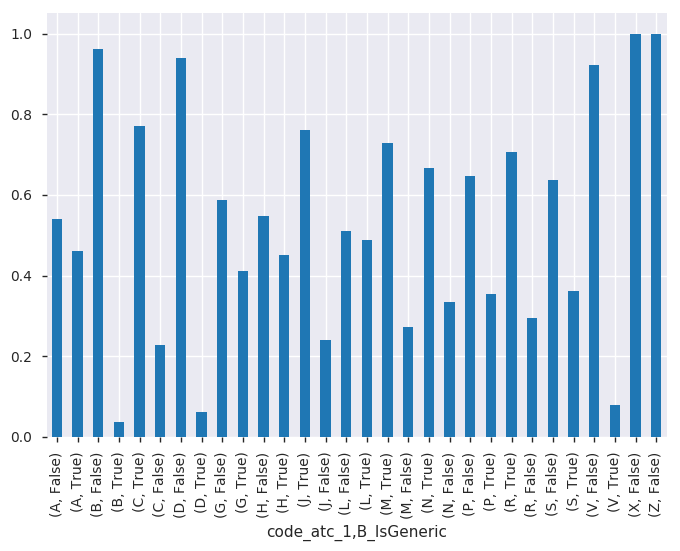

In [54]:
generic.plot(kind="bar")

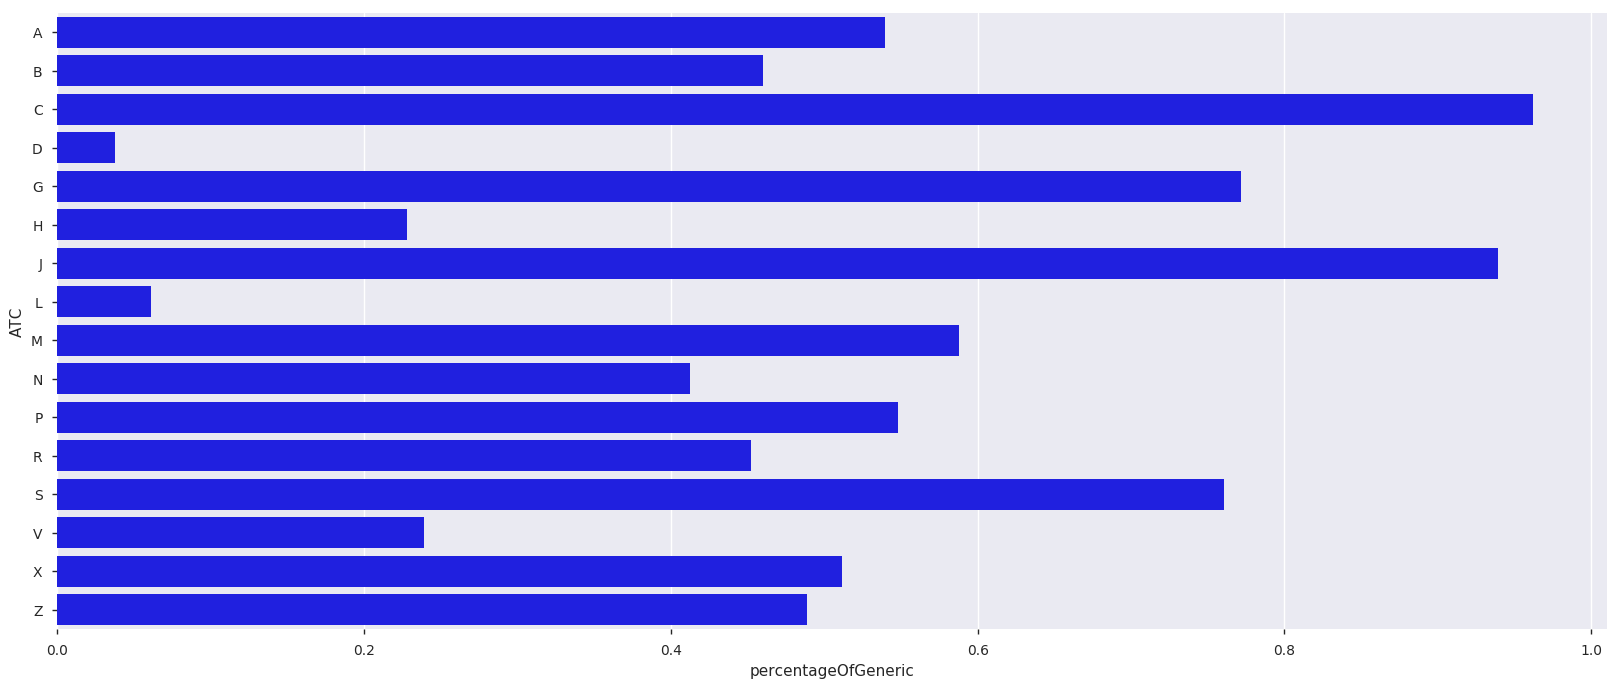

In [55]:
plt.figure(figsize=(20,8))
sns.barplot(data=newgeneric, x="percentageOfGeneric", y="ATC", color='blue' )

In [56]:
genericByService = df_work.groupby(["hosp_serv_id"])["B_IsGeneric"].value_counts(normalize=True)
genericByService

hosp_serv_id  B_IsGeneric
002           False          0.630610
              True           0.369390
190           False          0.605704
              True           0.394296
210           True           0.611370
              False          0.388630
220           True           0.598881
              False          0.401119
230           True           0.581920
              False          0.418080
250           True           0.590588
              False          0.409412
260           True           0.505588
              False          0.494412
270           False          0.557515
              True           0.442485
290           True           0.564628
              False          0.435372
300           True           0.632329
              False          0.367671
320           False          0.673674
              True           0.326326
340           True           0.667646
              False          0.332354
350           True           0.640741
              False     

In [57]:
genericByService.index

MultiIndex(levels=[['002', '190', '210', '220', '230', '250', '260', '270', '290', '300', '320', '340', '350', '370', '380', '490', '610', '620', '630', '640', '650', '660', '710', '720', '730', '740', '750', '770', '810', '840', '990'], [False, True]],
           codes=[[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 25, 26, 26, 27, 27, 28, 28, 29, 29, 30, 30], [0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1]],
           names=['hosp_serv_id', 'B_IsGeneric'])

In [58]:
newgenericByService = pd.DataFrame()

In [59]:
newgenericByService["percentageOfGeneric"] = genericByService.values

In [60]:
newgenericByService["Service"] = pd.Series([2, 190, 210, 220, 230, 250, 260, 270, 290, 300, 320, 340, 350, 370, 380, 490, 610, 620, 630, 640, 650, 660, 710, 720, 730, 740, 750, 760, 770, 810, 840, 990, 2, 190, 210, 220, 230, 250, 260, 270, 290, 300, 320, 340, 350, 370, 380, 490, 610, 620, 630, 640, 650, 660, 710, 720, 730, 740, 750, 760, 770, 810, 840, 990])

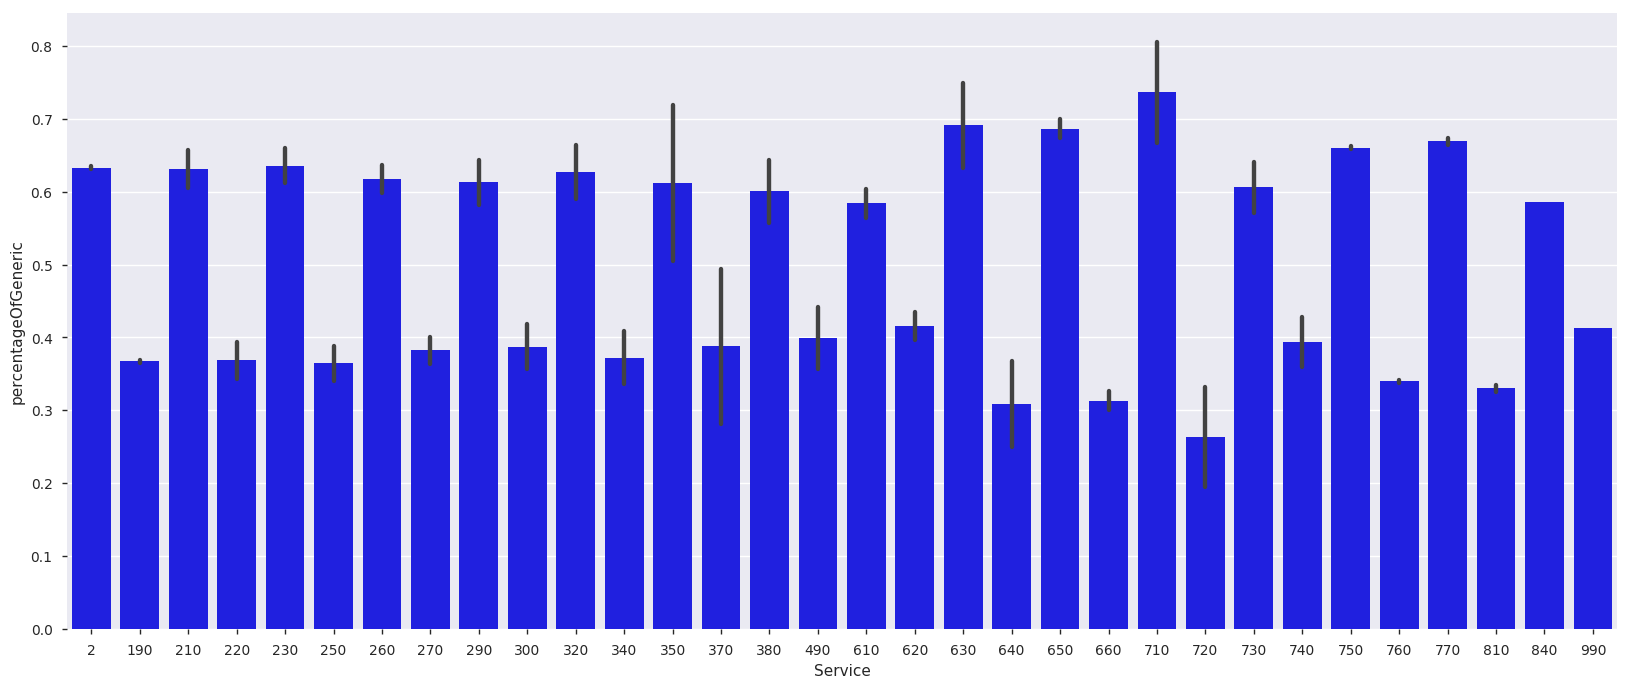

In [61]:
plt.figure(figsize=(20,8))
sns.barplot(data=newgenericByService, y="percentageOfGeneric", x="Service", color='blue' )

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1542611 entries, 22833075 to 26009296
Data columns (total 36 columns):
Province                    1542611 non-null object
Type                        1542611 non-null category
hosp_serv_id                1542611 non-null object
reimbt_cat_id               1542611 non-null int64
drug_code                   1542611 non-null object
realization_date            1542611 non-null object
quantity                    1542611 non-null int64
amount_reimb                1542611 non-null float64
amount_not_reimb            1542611 non-null float64
trim_pharma                 1542611 non-null float64
produit_pharma              1542611 non-null float64
type_drug_code              1538323 non-null category
famille_produit_pharma      1538323 non-null object
drug_name_aggregated        1538323 non-null object
conditionnement             1509986 non-null object
mode_administration         1510761 non-null object
date_debut_rembourse        1542611 non-n

In [63]:
df.drop_duplicates(inplace=True)

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1524505 entries, 22833075 to 26009296
Data columns (total 36 columns):
Province                    1524505 non-null object
Type                        1524505 non-null category
hosp_serv_id                1524505 non-null object
reimbt_cat_id               1524505 non-null int64
drug_code                   1524505 non-null object
realization_date            1524505 non-null object
quantity                    1524505 non-null int64
amount_reimb                1524505 non-null float64
amount_not_reimb            1524505 non-null float64
trim_pharma                 1524505 non-null float64
produit_pharma              1524505 non-null float64
type_drug_code              1520302 non-null category
famille_produit_pharma      1520302 non-null object
drug_name_aggregated        1520302 non-null object
conditionnement             1492665 non-null object
mode_administration         1493431 non-null object
date_debut_rembourse        1524505 non-n